<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Transformers/Attention_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention and Transfromers

## Imports

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from transformers import AutoTokenizer
from wordcloud import WordCloud

## Data preparation

### Download data

In [ ]:
%%capture
!wget https://github.com/Dimildizio/DS_course/raw/main/Neural_networks/Transformers/data/data_problems.xlsx

### Load data

In [40]:
dataset = pd.read_excel('data_problems.xlsx')

In [43]:
df_0 = dataset.drop(columns=['Unnamed: 0'])
df_0 = df_0.rename(columns={'Тема': 'Topic', 'Задача': 'Text'})

In [44]:
df_0.sample(10)

,Text,Topic
4780,"а) Есть 128 монет двух различных весов, монет ...",Инвариант
2883,"Требуется записать число вида 7...7, используя...",Теория чисел
2242,Подряд без пробелов выписали все чётные числа ...,Теория чисел
119,"В городе одна синяя площадь и n зелёных, причё...",Графы
2762,"Доказать, что если длины сторон прямоугольного...",Теория чисел
4097,Каждую букву исходного сообщения заменили её д...,Теория чисел
4463,Даны два многочлена от переменной x с целыми к...,Теория чисел
3396,"Доказать, что в любой бесконечной арифметическ...",Теория чисел
4214,Из чисел от 1 до 2n выбрано n + 1 число. Док...,Теория чисел
4352,"Найдите наименьшее натуральное число, представ...",Теория чисел


In [45]:
df_0.describe()

,Text,Topic
count,5273,5273
unique,4350,7
top,,Теория чисел
freq,7,2396


In [46]:
df_0["Topic"].unique()

array(['Графы', 'Геометрия', 'Многочлен', 'Комбинаторика', 'Теория чисел',
       'Инвариант', 'Дирихле'], dtype=object)

In [47]:
df_0['Topic'].value_counts()

Теория чисел     2396
Комбинаторика    1020
Дирихле           441
Многочлен         426
Графы             384
Геометрия         371
Инвариант         235
Name: Topic, dtype: int64

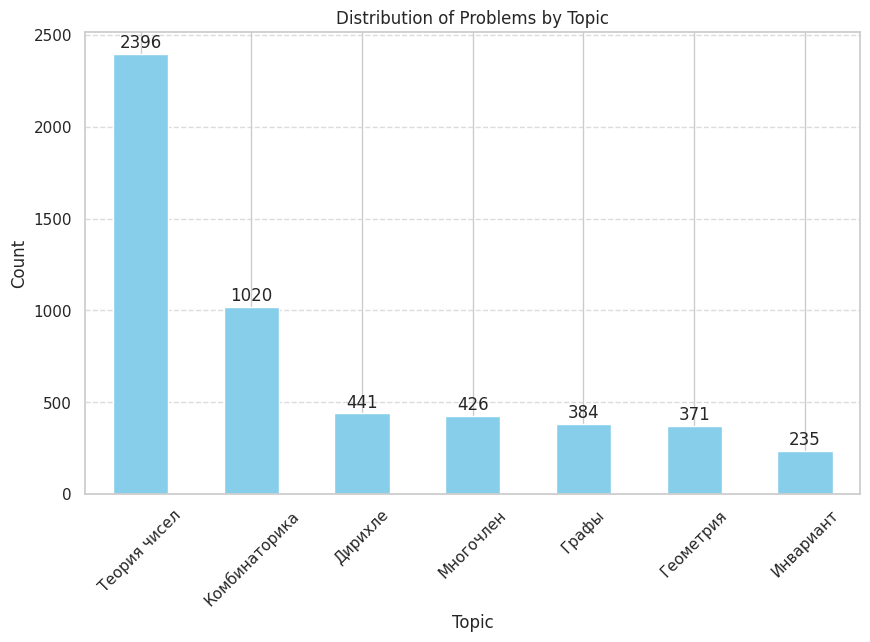

In [62]:
topics_counts = df_0['Topic'].value_counts()

plt.figure(figsize=(10, 6))
topics_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Problems by Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(topics_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

In [49]:
dfdict = {'Графы': 0, 'Геометрия': 1, 'Многочлен': 2, 'Комбинаторика': 3, 'Теория чисел': 4,
       'Инвариант': 5, 'Дирихле': 6}
df_1 = df_0.copy()
df_1['Topic'] = df_0['Topic'].replace(dfdict)
df_1["Topic"].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [63]:
df_2 = df_0.copy()
df_2['Text Length'] = df_2['Text'].apply(lambda x: len(str(x)))

<ipython-input-64-d3b538cbbea4>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_2['Topic'].unique(), rotation=45)


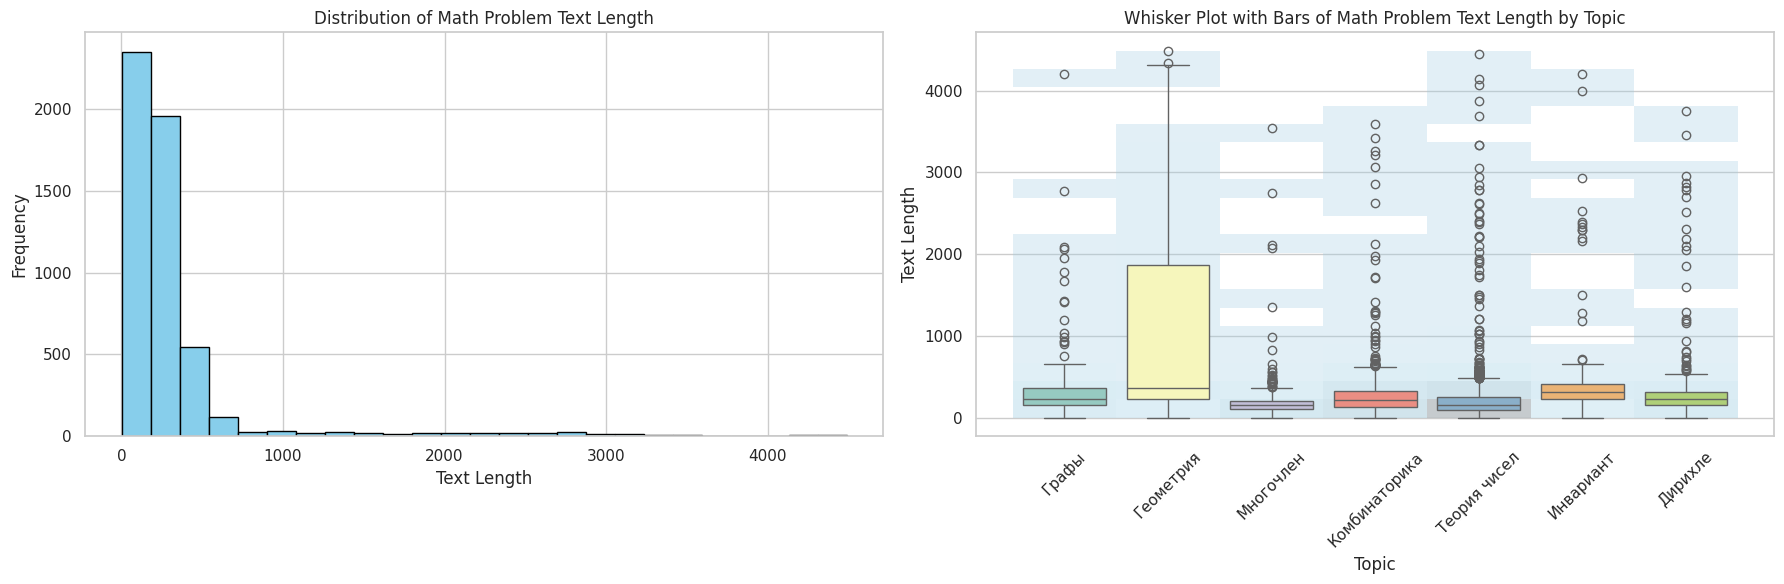

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the histogram of text lengths
axes[0].hist(df_2['Text Length'], bins=25, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Math Problem Text Length')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot the whisker plot with bars
sns.boxplot(ax=axes[1], x='Topic', y='Text Length', data=df_2, hue='Topic', palette='Set3')
sns.histplot(ax=axes[1], x='Topic', y='Text Length', data=df_2, color='skyblue', bins=20, kde=False, alpha=0.3)
axes[1].set_title('Whisker Plot with Bars of Math Problem Text Length by Topic')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Text Length')
axes[1].set_xticklabels(df_2['Topic'].unique(), rotation=45)

plt.tight_layout()
plt.show()

<ipython-input-73-c8722b80f49f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_filtered['Topic'].unique(), rotation=45)


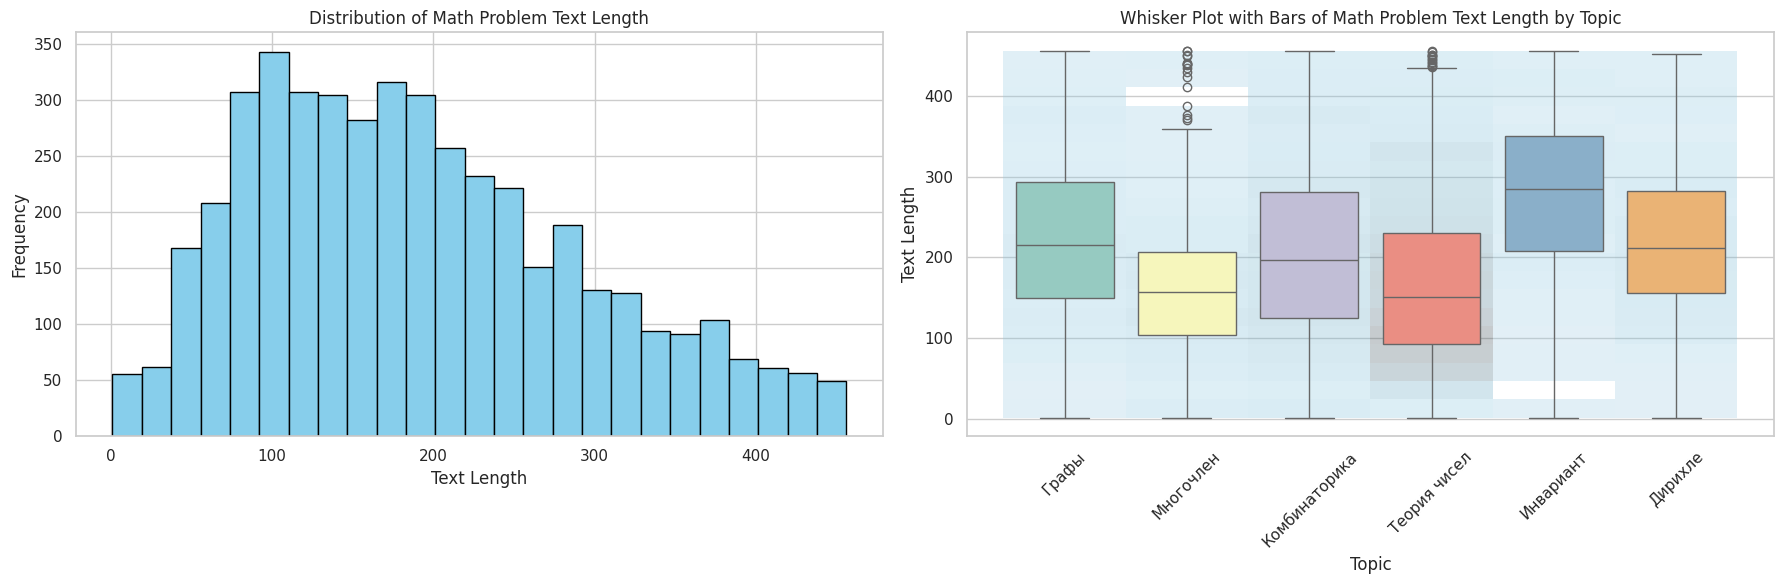

In [73]:
df_filtered = df_2[(df_2['Text Length'] <= df_2['Text Length'].quantile(0.75) * 1.5) &
                   (df_2['Topic'] != 'Геометрия')]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the histogram of text lengths
axes[0].hist(df_filtered['Text Length'], bins=25, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Math Problem Text Length')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot the whisker plot with bars
sns.boxplot(ax=axes[1], x='Topic', y='Text Length', data=df_filtered, hue='Topic', palette='Set3')
sns.histplot(ax=axes[1], x='Topic', y='Text Length', data=df_filtered, color='skyblue', bins=20, kde=False, alpha=0.3)
axes[1].set_title('Whisker Plot with Bars of Math Problem Text Length by Topic')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Text Length')
axes[1].set_xticklabels(df_filtered['Topic'].unique(), rotation=45)

plt.tight_layout()
plt.show()

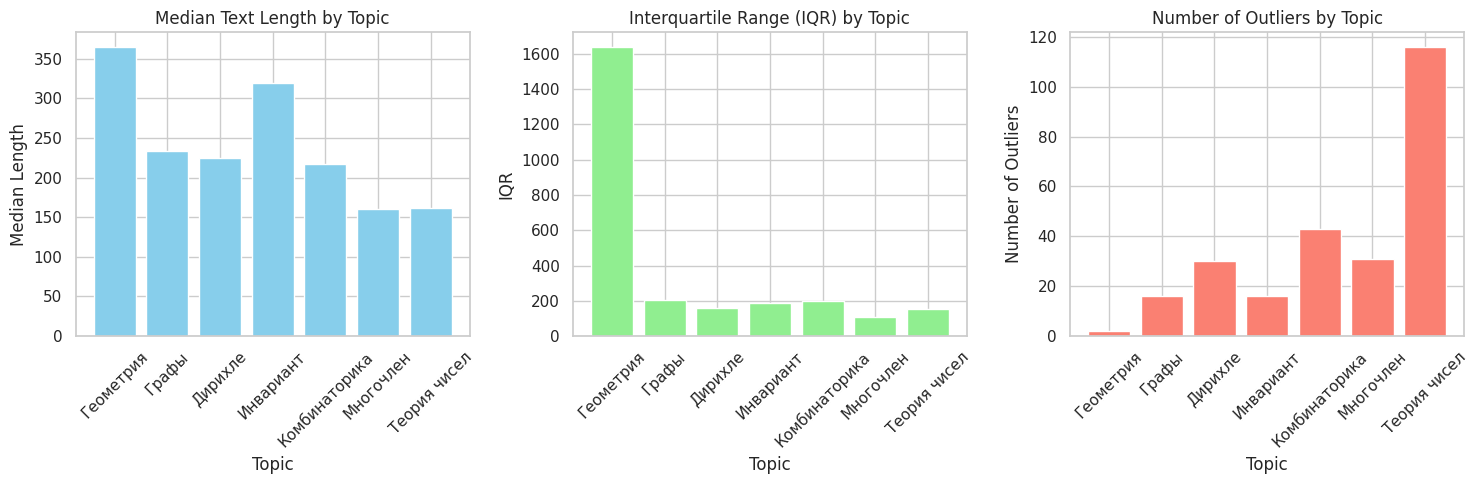

In [70]:
grouped_df = df_2.groupby('Topic')
median_lengths, outlier_counts, IQRs  = {}, {}, {}

for topic, group_df in grouped_df:
    # Calculate median length
    median_length = group_df['Text Length'].median()
    median_lengths[topic] = median_length

    # Calculate IQR
    Q1 = group_df['Text Length'].quantile(0.25)
    Q3 = group_df['Text Length'].quantile(0.75)
    IQR = Q3 - Q1
    IQRs[topic] = IQR

    # Calculate outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = group_df[(group_df['Text Length'] < lower_bound) | (group_df['Text Length'] > upper_bound)]
    outlier_counts[topic] = len(outliers)


median_lengths_df = pd.DataFrame(list(median_lengths.items()), columns=['Topic', 'Median Length'])
IQRs_df = pd.DataFrame(list(IQRs.items()), columns=['Topic', 'IQR'])
outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Topic', 'Outliers'])
stats_df = median_lengths_df.merge(IQRs_df, on='Topic').merge(outlier_counts_df, on='Topic')


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Median length
axes[0].bar(stats_df['Topic'], stats_df['Median Length'], color='skyblue')
axes[0].set_title('Median Text Length by Topic')
axes[0].set_xlabel('Topic')
axes[0].set_ylabel('Median Length')
axes[0].tick_params(axis='x', rotation=45)

# IQR
axes[1].bar(stats_df['Topic'], stats_df['IQR'], color='lightgreen')
axes[1].set_title('Interquartile Range (IQR) by Topic')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('IQR')
axes[1].tick_params(axis='x', rotation=45)

# Outliers
axes[2].bar(stats_df['Topic'], stats_df['Outliers'], color='salmon')
axes[2].set_title('Number of Outliers by Topic')
axes[2].set_xlabel('Topic')
axes[2].set_ylabel('Number of Outliers')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

As it is shown, we'll need to cut the outliers. Especially geometry. Since max median text length is ~350. We could Set it to 400

In [92]:
geometry_samples = df_2[df_2['Topic'] == 'Геометрия'].sample(5)

for index, row in geometry_samples.iterrows():
    print("Length:", len(row['Text']))
    print("Text:", row['Text'])
    print()

Length: 191
Text: Треугольник ABC вписан в окружность с центром O. Прямые AC и BC вторично пересекают окружность, проходящую через точки A, O и B, в точках E и K. Докажите, что прямые OC и EK перпендикулярны. 

Length: 1475
Text: 
В треугольнике ABC угол C — тупой. На стороне AB отмечены
точки E и H, на сторонах AC и BC — точки K и M соответственно.
Оказалось, что AH = AC, BE = BC, AE = AK, BH = BM. Докажите, что
точки E, H, K, M лежат на одной окружности.














					Прислать комментарий
				



			   
			
				Решение
			










					Задача
					
						108171







						Темы:
						 
					

						[
					



								Четыре точки, лежащие на одной окружности							



						]
					



						[
					



								Три точки, лежащие на одной прямой							



						]
					



						[
					



								Углы, опирающиеся на равные дуги и равные хорды							



						]
					



						[
					



								Вписанные четырехугольники							



						]
					



						[
					



								Три 

In [94]:
text_contains_comment = df_2[df_2['Text'].str.contains('Прислать комментарий')]
num_texts_with_comment = len(text_contains_comment)
print("Number of texts containing 'Прислать комментарий':", num_texts_with_comment)
average_length = text_contains_comment['Text'].apply(len).mean()
print("Average length:", average_length)

Number of texts containing 'Прислать комментарий': 323
Average length: 1849.6934984520124


In [100]:
topics_for_comment_text = text_contains_comment[text_contains_comment['Text'].str.contains('Прислать комментарий', case=False)]['Topic']
print(topics_for_comment_text.unique())


['Графы' 'Геометрия' 'Многочлен' 'Комбинаторика' 'Теория чисел'
 'Инвариант' 'Дирихле']


<ipython-input-104-448800f9697b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Text Length'] = df_3['Text'].apply(lambda x: len(str(x)))
<ipython-input-104-448800f9697b>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_3['Topic'].unique(), rotation=45)


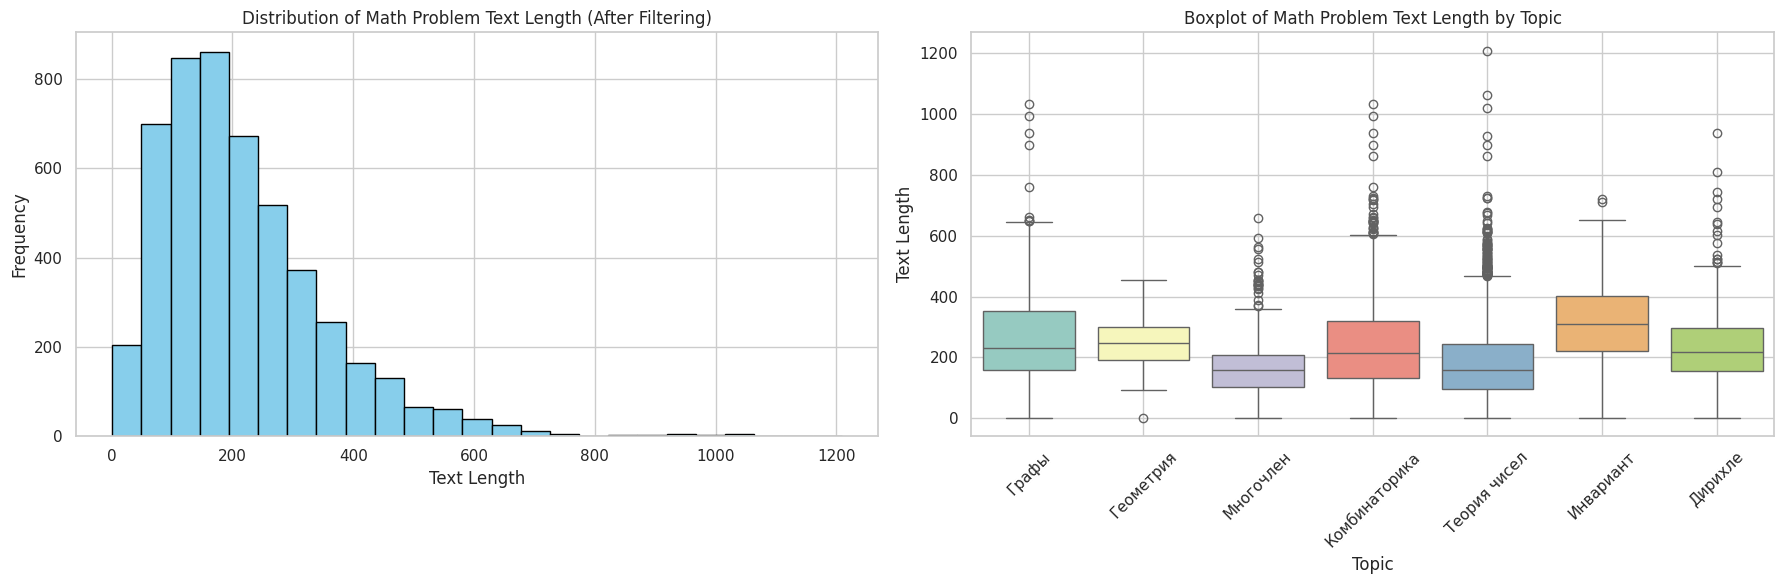

In [104]:
df_3 = df_2[~df_2['Text'].str.contains("Прислать комментарий")]
df_3['Text Length'] = df_3['Text'].apply(lambda x: len(str(x)))

topic_stats = df_3.groupby('Topic').describe()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot histogram
axes[0].hist(df_3['Text Length'], bins=25, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Math Problem Text Length (After Filtering)')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot boxplot
sns.boxplot(ax=axes[1], x='Topic', y='Text Length', data=df_3, hue='Topic', palette='Set3', showfliers=True)
axes[1].set_title('Boxplot of Math Problem Text Length by Topic')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Text Length')
axes[1].set_xticklabels(df_3['Topic'].unique(), rotation=45)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [111]:
short_texts = df_3[df_3['Text Length'] < 60]
print(short_texts)

                                                   Text         Topic  \
26                                                              Графы   
138                 В некотором государстве 101 город.          Графы   
198                                                  \n         Графы   
276   б) Тот же вопрос для решётки 5×5 (всего 36 узл...         Графы   
284   б) Тот же вопрос для решётки 7×7 (всего 64 узл...         Графы   
...                                                 ...           ...   
4485  Решить в целых числах уравнение  x² + y² + z² ...  Теория чисел   
4622                              См. задачу 73546 а).      Инвариант   
4762                                                        Инвариант   
5060                В некотором государстве 101 город.        Дирихле   
5254                                                          Дирихле   

      Text Length  
26              1  
138            35  
198             1  
276            51  
284            50  
...

#### Trim values

We'll remove all entries that have "Прислать комментарий" since they are just wrongly parsed data as well as those that are shorter than 50 symbols.

In [113]:
df_4 = df_2[~df_2['Text'].str.contains("Прислать комментарий") & (df_2['Text Length'] >= 50)]

<ipython-input-142-9ce1da20c4bb>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


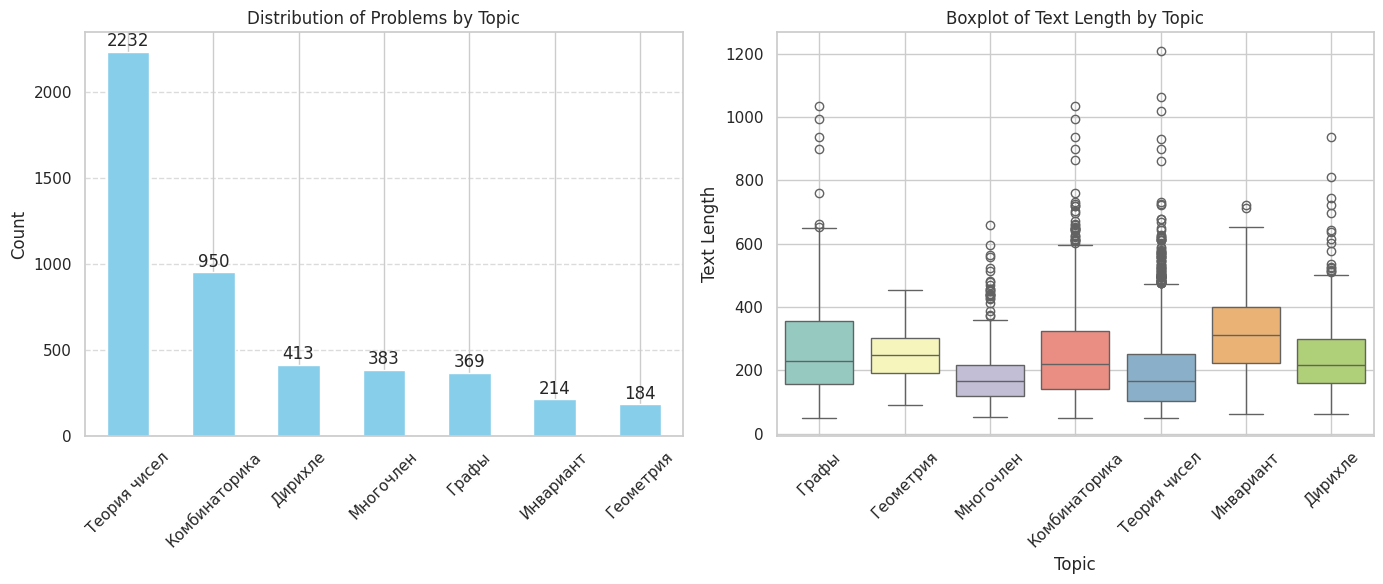

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot
topics_counts = df_4['Topic'].value_counts()
topics_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Distribution of Problems by Topic')
ax1.set_ylabel('Count')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
for i, count in enumerate(topics_counts):
    ax1.text(i, count + 10, str(count), ha='center', va='bottom')

# Box plot
sns.boxplot(x='Topic', y='Text Length', data=df_4, ax=ax2, hue='Topic', palette='Set3')
ax2.set_title('Boxplot of Text Length by Topic')
ax2.set_xlabel('Topic')
ax2.set_ylabel('Text Length')
ax2.grid(True)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


## Tokenize

In [145]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [182]:
def tokenize_text(text, pad=False):
  if pad:
    tokens = tokenizer.tokenize(text,  padding='max_length', truncation=True, max_length=128, return_tensors='pt')
  else:
    tokens = tokenizer.tokenize(text)
  return " ".join(tokens)

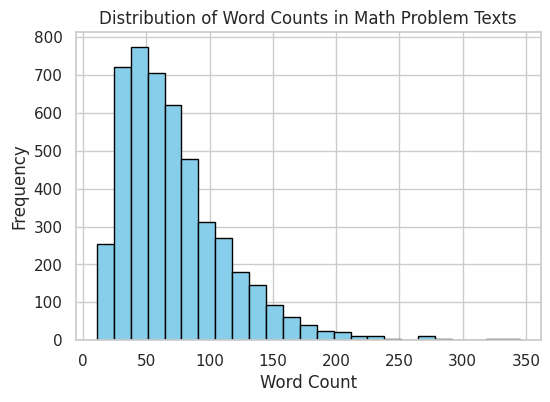

count    4745.000000
mean       72.009694
std        41.899225
min        11.000000
25%        41.000000
50%        63.000000
75%        92.000000
max       345.000000
Name: Token_Count, dtype: float64
На ##тура ##льное число $ k $ на ##зов ##ём интерес ##ным , если произведение первых $ k $ про ##стых чисел дели ##тся на $ k $ ( например , произведение первых двух про ##стых чисел [UNK] это 2 · 3 = 6 , и 2 [UNK] число интерес ##ное ) . Како ##е на ##иб ##оль ##шее количество интерес ##ных чисел может и ##дт ##и подряд ?

На острове жив ##ут л ##же ##цы , которые всегда л ##гу ##т , и р ##ы ##ца ##ри , которые всегда говорят прав ##ду . К ##аж ##дый из них сделал по два за ##явления : 1 ) " Среди м ##ои ##х др ##уз ##ей [UNK] не ##чёт ##ное количество р ##ы ##ца ##рей " ; 2 ) " Среди м ##ои ##х др ##уз ##ей [UNK] ч ##ёт ##ное количество л ##же ##цов " . Ч ##ёт ##но или не ##чёт ##но количество жителей острова ?

У в ##ед ##у ##щего есть коло ##да из 52 карт . З ##рите ##ли хотя ##т уз 

In [179]:
df_5=df_4.copy()
df_5['Tokenized_Text'] = df_5['Text'].apply(tokenize_text)
df_5['Token_Count'] = df_5['Tokenized_Text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6, 4))
plt.hist(df_5['Token_Count'], bins=25, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Math Problem Texts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(df_5['Token_Count'].describe())
sample_tokenized_text = df_5['Tokenized_Text'].sample(5)
for text in sample_tokenized_text:
    print(text)
    print()

Not actually what we want since we need padding after all

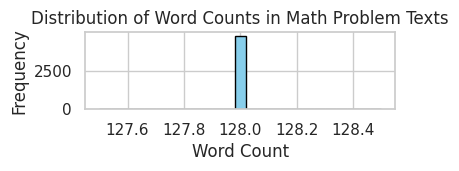

count    4745.0
mean      128.0
std         0.0
min       128.0
25%       128.0
50%       128.0
75%       128.0
max       128.0
Name: Token_Count, dtype: float64
а ) П ##ус ##ть m ##0 и m ##1 [UNK] цел ##ые числа , & n ##bs ##p ##0 < m ##1 ≤ m ##0 . До ##ка ##жит ##е , что при не ##кото ##ром k > 1 существуют такие цел ##ые числа a ##0 , a ##1 , . . . , ak и m2 , . . . , mk , что m ##1 > m2 > m ##3 > . . . > mk > 0 , ak > 1 , m ##0 = m ##1 ##a ##0 + m2 , m ##1 = m2 ##a ##1 + m ##3 , m2 = m ##3 ##a ##2 + m ##4 , . . . mk [UNK] 2 = mk [UNK] 1a ##k [UNK]

П ##ус ##ть S ( x ) [UNK] сум ##ма ц ##и ##ф ##р на ##тура ##льного числа x . Р ##еши ##те у ##рав ##нение x + S ( x ) = 2001 . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [186]:
df_6=df_4.copy()
df_6['Tokenized_Text'] = df_6['Text'].apply(lambda x: tokenize_text(x, True))
df_6['Token_Count'] = df_6['Tokenized_Text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(4, 1))
plt.hist(df_6['Token_Count'], bins=25, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Math Problem Texts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(df_6['Token_Count'].describe())
sample_tokenized_text = df_6['Tokenized_Text'].sample(5)
for text in sample_tokenized_text:
    print(text)
    print()

### Word frequency analysis

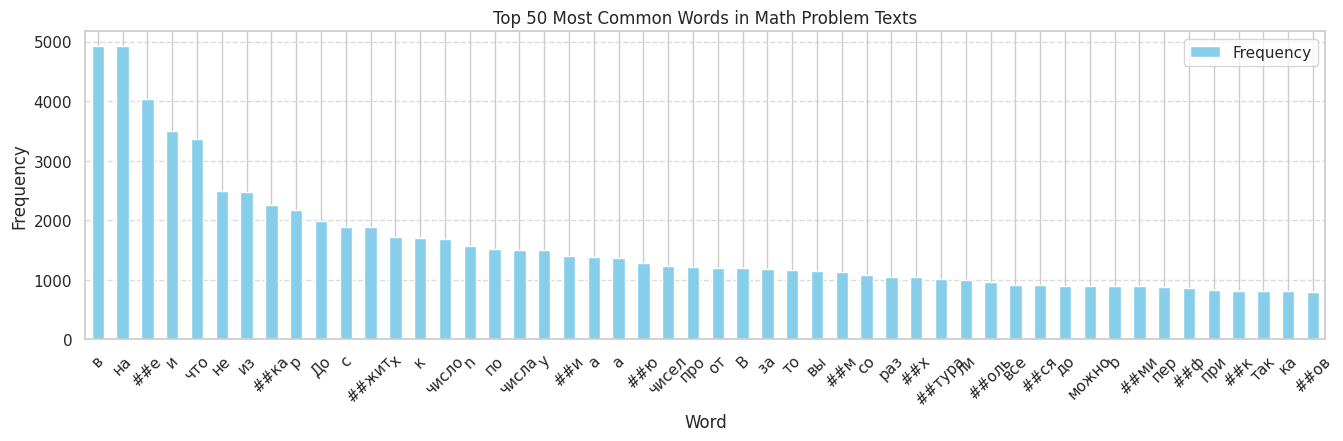

In [202]:
from collections import Counter
all_tokens = [token for tokens_list in df_6['Tokenized_Text'] for token in tokens_list.split() if token not in ['[PAD]', '[UNK]']+list(',.!@#$%^&*()+-=?/;:1234567890[]{}<>|')]
word_freq = Counter(all_tokens)
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Plot the top N most frequent words
top_n = 50
word_freq_df.head(top_n).plot(kind='bar', figsize=(16, 4), color='skyblue')
plt.title(f'Top {top_n} Most Common Words in Math Problem Texts')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()